# Fine-Tuning a Large Language Model to Translate Text Into Neo4j Cypher Syntax

#### Introduction-

Generative AI and large language models (LLMs) have created a new era in data science; they have also revolutionized our personal and professional lives in the process. We now have novelties ranging from supercharged digital assistants that can manage email to omniscient chatbots which communicate with data stores across industries. These technologies are driving are facillitating new forms of convenience, productivity, and connectivity.

One interesting way in which LLM's have changed the game for developers and data scientists is through their ability to lend a helping hand when it comes to writing code for programming purposes. One popular language is cypher which was developed by neo4j to operate its graph relation databases.

In this post, we will fine-tune a large language model to learn cypher syntax so that it will be better able to assist end-users in retrieving data from neo4j databases. Then, we will conduct a test to measure the model's improved abilities using a technique called the BLEU score. BLEU stands for "bilingual evaluation understudy" and this was originally designed as a metric to compare machine translations of texts into different languages as compared to their human translations. Here we will use it to compare the output of our finetuned model in reference to the human translations that were contained in the original fine-tuning dataset.

---
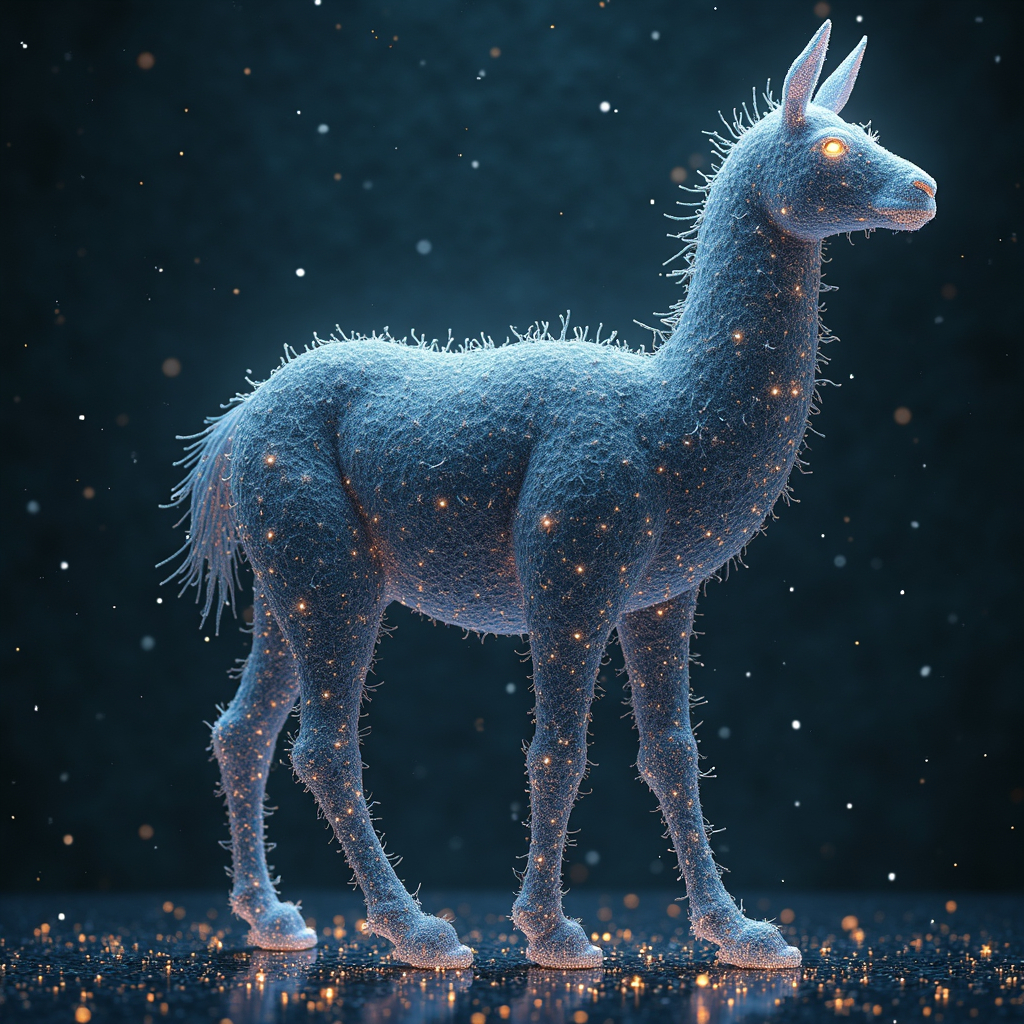


In order to achieve our responses within a reasonable frame of time, we recruited the assistance of an A100 GPU in google colab, however, for the purpose of sharing our results- it is not feasible to show that notebook due to the hardware compatibility issues. However, we will load the fine-tuned model into this notebook and evaluate it against a baseline Llama 3.1 model by using the test set from the text2cypher training data on HuggingFace.

In [ ]:
%%capture

# Unsloth finetuning setup for colab
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install colab-xterm
%load_ext colabxterm

In [ ]:
%%capture

# Install ollama
!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
# Import libraries
from datasets import load_dataset, Dataset
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
from trl import SFTTrainer
from transformers import TrainingArguments
import shutil
from google.colab import drive
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from transformers import TextStreamer
from unsloth.chat_templates import get_chat_template
import subprocess
import random
import csv
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import re
import numpy as np
import os

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Function to call ollama
def run_ollama(prompt, model = "llama3.1"):

    process = subprocess.run(['ollama', 'run', model], input = prompt.encode(), stdout = subprocess.PIPE, stderr = subprocess.PIPE)

    return process.stdout.decode()

In [ ]:
# Function to calculate bleu score
def calculate_bleu(x, y):

    return sentence_bleu([x], y)

In [ ]:
# Connect to google drive for file storage purposes
drive.mount('/content/drive') #, force_remount = True)

Mounted at /content/drive


In [ ]:
# Load a dataset for cypher queries
ds = load_dataset("neo4j/text2cypher-2025v1")

README.md:   0%|          | 0.00/109 [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/4.52M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/594k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/35946 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4438 [00:00<?, ? examples/s]

In [ ]:
# Rename column for compatibility
ds['test'] = ds['test'].rename_column('cypher', 'output')

In [ ]:
# Examine dataset features
ds['test'][0].keys()

dict_keys(['question', 'schema', 'output', 'data_source', 'instance_id', 'database_reference_alias'])

In [ ]:
# Grab the stop token to prevent endless generation
EOS_TOKEN = '<|eot_id|>'

# Function to format prompts
def formatting_prompts(examples):

    prompt = '''
                You are an assistant designed to generate cypher statements to allow querying of a graph database. Use only the provided relationship types and properties in the provided schema.

                ### Schema:
                {}

                ### Question:
                {}

                ### Response:
            '''

    schemas = examples["schema"]
    questions = examples["question"]
    outputs = examples["output"]

    texts = []

    for schema, question, output in zip(schemas, questions, outputs):

        # Must add EOS_TOKEN, otherwise your generation will go on forever
        text = prompt.format(schema, question, output) + EOS_TOKEN
        texts.append(text)

    return { "text" : texts, }

In [ ]:
# Apply function to convert prompts for training formatting
ds1 = ds.map(formatting_prompts, batched = True,)

Map:   0%|          | 0/35946 [00:00<?, ? examples/s]

Map:   0%|          | 0/4438 [00:00<?, ? examples/s]

In [ ]:
# Show the converted prompts used for training
print(ds1['test'][0]['text'])


                You are an assistant designed to generate cypher statements to allow querying of a graph database. Use only the provided relationship types and properties in the provided schema.

                ### Schema:
                Node properties:
- **Product**
  - `productName`: STRING Example: "Chai"
  - `quantityPerUnit`: STRING Example: "10 boxes x 20 bags"
  - `unitsOnOrder`: INTEGER Min: 0, Max: 100
  - `supplierID`: STRING Example: "1"
  - `productID`: STRING Example: "1"
  - `discontinued`: BOOLEAN 
  - `categoryID`: STRING Available options: ['1', '2', '7', '6', '8', '4', '3', '5']
  - `reorderLevel`: INTEGER Min: 0, Max: 30
  - `unitsInStock`: INTEGER Min: 0, Max: 125
  - `unitPrice`: FLOAT Min: 2.5, Max: 263.5
- **Category**
  - `picture`: STRING Available options: ['0x151C2F00020000000D000E0014002100FFFFFFFF4269746D']
  - `categoryID`: STRING Available options: ['1', '2', '3', '4', '5', '6', '7', '8']
  - `description`: STRING Available options: ['Soft drinks, cof

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/models')

In [ ]:
!ls

all-MiniLM-L6-v2
cuda-repo-ubuntu2204-12-2-local_12.2.2-535.104.05-1_amd64.deb
finetunedllamacyphermodel.gguf
latestfinetunedllamacyphermodel
latestfinetunedllamacyphermodel.gguf
llama3.3
llama.cpp
Modelfile
msmarco-MiniLM-L-12-v3
stable-diffusion


In [ ]:
!nohup ollama serve &

nohup: appending output to 'nohup.out'


In [ ]:
# Open up a terminal instance and serve the llama model
#!ollama serve
!ollama pull llama3.1

In [ ]:
# Open a terminal and run "ollama serve"
# Then create the ollama copy of the model for inference
#!ollama create latestfinetunedllamacyphermodel -f Modelfile

In [ ]:
# Assign the data to a test set
test = ds1['test']

# Run the finetuned model for inspection
%time print(run_ollama(test['text'][0], model = 'latestfinetunedllamacyphermodel').strip())

assistant<|end_header_id|>
                MATCH (s:Supplier)<-[:SUPPLIES]-(p:Product)\nWITH s.supplierID AS supplier, avg(p.unitPrice) AS averageUnitPrice\nORDER BY averageUnitPrice DESC\nLIMIT 5\nRETURN supplier, averageUnitPrice
CPU times: user 47.8 ms, sys: 10.8 ms, total: 58.6 ms
Wall time: 9.32 s


In [ ]:
%time print(run_ollama(test['text'][0], model = 'llama3.1'))

To answer this question, we need to write a Cypher query that calculates the average unit price for each supplier and returns the top 5 suppliers. Here's how you can do it:

```cypher
MATCH (s:Supplier)-[:SUPPLIES]->(p:Product)
WITH s.supplierID AS supplierId, AVG(p.unitPrice) as avgUnitPrice
GROUP BY s.supplierID
ORDER BY avgUnitPrice DESC
LIMIT 5
RETURN s.companyName, supplierId, avgUnitPrice;
```

This Cypher query does the following:

- It matches each `Supplier` node with the products it supplies (`(s:Supplier)-[:SUPPLIES]->(p:Product)`).
- Then, it calculates the average unit price for each product supplied by a supplier (`WITH s.supplierID AS supplierId, AVG(p.unitPrice) as avgUnitPrice`).
- It groups these calculations by supplier ID (`GROUP BY s.supplierID`).
- The results are ordered in descending order based on the average unit price (`ORDER BY avgUnitPrice DESC`).
- Finally, it limits the results to the top 5 suppliers with the highest average unit prices and returns their 

In [ ]:
# Load the responses obtained from running the models on GPU
df = pd.read_csv('/content/drive/My Drive/latestfinetunedcyphermodelresult.csv')

In [ ]:
# Clean the output data
df['finetuned_output'] = df['finetuned_output'].apply(lambda x: x.replace('<|start_header_id|>', '').replace('assistant', '').replace('<|end_header_id|>\n', ''))
df['finetuned_output'] = df['finetuned_output'].apply(lambda x: x.strip().replace("\\n", " \n").replace(r"\n", ' ').lower())

# Format the resposnes
df['cypher'] = df['cypher'].apply(lambda x: x.lower().replace(r"\n", ' '))
df['llama_output'] = df['llama_output'].apply(lambda x: x.lower().replace(r"\n", ' '))

# Extract the patterns from the data
df['filtered_cypher'] = df['cypher'].apply(lambda x: re.sub(r'\W+', ' ', x).split())
df['filtered_llama_output'] = df['llama_output'].apply(lambda x: re.sub(r'\W+', ' ', x).split())
df['filtered_finetuned_output'] = df['finetuned_output'].apply(lambda x: re.sub(r'\W+', ' ', x).split())

In [ ]:
df.head()

,input,cypher,llama_output,finetuned_output,filtered_cypher,filtered_llama_output,filtered_finetuned_output
0,\n You are an assistant designe...,match (q:question) where q.answer_count > 1 re...,"to solve this problem, we need to create a cyp...",match (q:question) \nwhere q.answer_count > 1 ...,"[match, q, question, where, q, answer_count, 1...","[to, solve, this, problem, we, need, to, creat...","[match, q, question, where, q, answer_count, 1..."
1,\n You are an assistant designe...,match (a:author {name:'jane smith'})-[:wrote]-...,select book.publicationyear from author as aut...,match (a:author)-[:wrote]->(b:book) \nwhere a....,"[match, a, author, name, jane, smith, wrote, b...","[select, book, publicationyear, from, author, ...","[match, a, author, wrote, b, book, where, a, n..."
2,\n You are an assistant designe...,match (s:supplier)-[:supplies]->(p:product) wh...,"to answer your question, we can write the foll...",match (p:product)<-[:supplies]-(s:supplier) \n...,"[match, s, supplier, supplies, p, product, whe...","[to, answer, your, question, we, can, write, t...","[match, p, product, supplies, s, supplier, whe..."
3,\n You are an assistant designe...,match (m:movie)-[:directed]-(p:person) where m...,to generate a cypher statement to answer this ...,match (m:movie) \nwhere m.votes > 1000 \nmatch...,"[match, m, movie, directed, p, person, where, ...","[to, generate, a, cypher, statement, to, answe...","[match, m, movie, where, m, votes, 1000, match..."
4,\n You are an assistant designe...,match (a:article {article_id:'2007'})-[r:publi...,"to answer your question, we need to create a c...",match (a:article {article_id:'2007'})-[r:publi...,"[match, a, article, article_id, 2007, r, publi...","[to, answer, your, question, we, need, to, cre...","[match, a, article, article_id, 2007, r, publi..."


In [ ]:
# Compute the bleu scores
df['sentence_bleu_score'] = df.apply(lambda x: calculate_bleu(x['filtered_cypher'], x['filtered_llama_output']), axis = 1)
df['finetuned_sentence_bleu_score'] = df.apply(lambda x: calculate_bleu(x['filtered_cypher'], x['filtered_finetuned_output']), axis = 1)

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
# Get result
print(f"Overall Avg. Bleu Score for the Fine-tuned Model is  {round(np.mean(df['finetuned_sentence_bleu_score']), 3)}")
print(f"Overall Avg. Bleu Score for the Base Model LlAmA3.1 is {round(np.mean(df['sentence_bleu_score']), 3)}")

Overall Avg. Bleu Score for the Fine-tuned Model is  0.487
Overall Avg. Bleu Score for the Base Model LlAmA3.1 is 0.051


#### Conclusion-

Well the results are in and it would seem as if, for the purpose of learning cypher syntax, the LLM was able to achieve a 10X improvement in score through the use of fine-tuning on a specialized dataset of cypher queries.

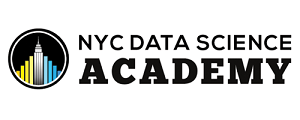